Importando Bibliotecas

In [1]:
import arcpy
import pandas as pd
from arcpy import env
import os 
env.overwriteOutput = True
from arcgis.features import GeoSeriesAccessor, GeoAccessor

Definindo Workspace e criando GDB

In [2]:
path = r"D:\SL_PYHON_GIS\08_UDM_ALL\Data"
arcpy.CreateFileGDB_management(path, "Projeto.gdb")
path_gdb = r"D:\SL_PYHON_GIS\08_UDM_ALL\Data\Projeto.gdb"
arcpy.env.workspace = path_gdb

Seleção de município a adição de coluna

In [3]:
fc = os.path.join(path,'PA_Municipios_2021.shp')

In [4]:
select = "Altamira"

In [5]:
a = f"NM_MUN = '{select}'"
b = select+'.shp'

In [6]:
arcpy.Select_analysis(fc,select,a)
fcs = os.path.join(path,b)

In [7]:
arcpy.management.AddField(select, "Classe", "TEXT", None, None, 50, '', "NULLABLE", "NON_REQUIRED", '') 
#coluna que vai identificar o limite municipal como Prioridade 1

<Result 'D:\\SL_PYHON_GIS\\08_UDM_ALL\\Data\\Projeto.gdb\\Altamira'>

Definição de variáveis, inputs e outputs

In [8]:
r = (str(60)) #raio de interesse
b = select+'_Buffer_'+f'{r}_km'#buffer
c = f'comunidades_em_{select}_'+'raio_de_'+f'{r}_km'#comunidades selecionas no raio de interesse
d = 'Prioridade2'# nome dado à diferença simétrica entre o limite municipal e o buffer gerado
e = 'Select_Prioridade2' #nome dado ao merge gerado entre o limite municipal e o buffer
f = f'comunidades_em_{select}_'+'raio_de_'+f'{r}_km_categorias'#comunidades selecionas no raio de interesse por categoria

In [9]:
fcs = os.path.join(path_gdb,f'{select}')# municipio selecionado
fcb = os.path.join(path_gdb,b) #buffer gerado
fcc = os.path.join(path_gdb,c) #comunidades selecionadas na área de interesse
fcd = os.path.join(path_gdb,d) #diferença simétrica
fce = os.path.join(path_gdb,e) #merge(junção) enre limite municipal e buffer
fcf = os.path.join(path_gdb,f) #comunidades selecionadas na área de interesse com informação da categoria (prioridade 1 e 2)
comunidades = os.path.join(path,'aglomerado_rural.shp') #comunidades usadas na análise

Buffer, Diferença Simétrica e Merge

In [1]:
arcpy.analysis.Buffer(fcs, fcb, f"{r} Kilometers", "FULL", "ROUND", "NONE", None, "PLANAR")

In [2]:
arcpy.analysis.SymDiff(
    in_features= fcb,
    update_features= fcs,
    out_feature_class=fcd,
    join_attributes="ALL",
    cluster_tolerance=None)

In [3]:
arcpy.management.AddField(fcd, "Classe", "TEXT", None, None, 50, '', "NULLABLE", "NON_REQUIRED", '')

In [13]:
arcpy.management.Merge([select, fcd], 
                       fce, "", "ADD_SOURCE_INFO")

<Result 'D:\\SL_PYHON_GIS\\08_UDM_ALL\\Data\\Projeto.gdb\\Select_Prioridade2'>

Definindo áreas de Prioridades

In [14]:
with arcpy.da.UpdateCursor(fce,['OBJECTID','Classe']) as cursor:
    for row in cursor:
        if row[0] == 1:
            row[1] = 'Prioridade 1'
        if row[0] == 2:
            row[1] ='Prioridade 2'
        
        cursor.updateRow(row)

Clip

In [15]:
arcpy.analysis.Clip(comunidades, fcb, fcc, None)
arcpy.management.AddField(fcc, "Classe", "TEXT", None, None, 50, '', "NULLABLE", "NON_REQUIRED", '')

<Result 'D:\\SL_PYHON_GIS\\08_UDM_ALL\\Data\\Projeto.gdb\\comunidades_em_Altamira_raio_de_60_km'>

Clipando pontos por categoria de prioridade

In [16]:
input_points = fcc
clip_polygon = fce
output_points = fcf

# Defini um dicionário para atribuir valores às categorias
category_dict = {
    "Prioridade 1": 10,
    "Prioridade 2": 20,
}

# Cria uma feature layer a partir do input de pontos
arcpy.MakeFeatureLayer_management(input_points, 'points')

# loop sobre as categorias e clipa os pontos por cada categoria de poligono
with arcpy.da.SearchCursor(clip_polygon, ["Classe", "SHAPE@"]) as cursor:
    for row in cursor:
        input_points = row[0]
        clip_polygon = row[1]

        # Seleciona os pontos que intersectam as categorias do poligono
        arcpy.SelectLayerByLocation_management("points", "INTERSECT", clip_polygon)

        # calcula os valores de categorias pelos pontos selecionados
        category = category_dict[input_points]

        # atualiza o campo de categoria pelos ponttos selecionados e limpa a seleçãoZ
        arcpy.CalculateField_management("points", "Classe", category)
        arcpy.SelectLayerByAttribute_management("points", "CLEAR_SELECTION")


In [17]:
arcpy.conversion.FeatureClassToFeatureClass(
    in_features="points",
    out_path= path_gdb,
    out_name= f)

<Result 'D:\\SL_PYHON_GIS\\08_UDM_ALL\\Data\\Projeto.gdb\\comunidades_em_Altamira_raio_de_60_km_categorias'>

In [18]:
arcpy.management.AddField(fcf, "Categoria", "TEXT", None, None, 50, '', "NULLABLE", "NON_REQUIRED", '')

<Result 'D:\\SL_PYHON_GIS\\08_UDM_ALL\\Data\\Projeto.gdb\\comunidades_em_Altamira_raio_de_60_km_categorias'>

In [19]:
fcf = os.path.join(path_gdb,f)

In [20]:
with arcpy.da.UpdateCursor(fcf,['Classe','Categoria']) as cursor:
    for row in cursor:
        if row[0] == str(10):
            row[1] = 'Prioridade 1'
        if row[0] == str(20):
            row[1] ='Prioridade 2'
        
        cursor.updateRow(row)

Lendo análise como um geodataframe

In [21]:
sdf = pd.DataFrame.spatial.from_featureclass(fcf)
sdf = sdf.drop(['SHAPE'],axis=1)
sdf = sdf.sort_values(['Categoria'])
sdf.head()

,OBJECTID,nome,Classe,Categoria
51,52,Aldeia Indígena Nassepotiti,10,Prioridade 1
21,22,Seringal São Jorge,10,Prioridade 1
56,57,Cachoeira,10,Prioridade 1
50,51,Agrovila Princesa do Xingu,10,Prioridade 1
6,7,Agrovila União,10,Prioridade 1


In [22]:
qtd = sdf.shape[0]
qtd

68

In [23]:
sdf.to_excel(fr'D:\SL_PYHON_GIS\08_UDM_ALL\Data\{c}.xlsx')

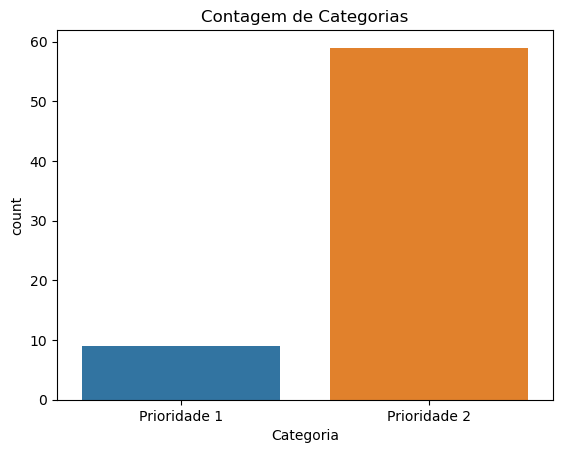

<Figure size 640x480 with 0 Axes>

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# criar um gráfico de barras com as contagens das categorias
sns.countplot(x='Categoria', data=sdf)

# adicionar um título ao gráfico
plt.title('Contagem de Categorias')

# mostrar o gráfico
plt.show()

# salvar o gráfico em formato PNG
plt.savefig('contagem_categorias.png')
